# CNN with Keras on CIFAR10

Modify your MLP version from the previous exercise towards Convolutional Neural Networks.

## Loading the packages

In [1]:
# First, import TF and get its version.
import tensorflow as tf
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout
from tensorflow.keras import utils
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix

%matplotlib inline

# fix random seed for reproducibility
np.random.seed(42)

# GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Loading the raw data

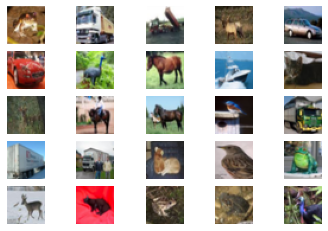

In [3]:
def show_imgs(X):
    plt.figure(1)
    k = 0
    for i in range(0,5):
        for j in range(0,5):
            plt.subplot2grid((5,5),(i,j))
            plt.imshow(X[k], cmap='gray')
            k = k+1
            plt.axis('off')
    # show the plot
    plt.show()
    
# Load data & split data between train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

show_imgs(X_train)

In [4]:
# Normalize input
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

n_classes = 10
# Conversion to class vectors
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)

50000 train samples
10000 test samples


## Simple CNN

### Define the network

In [5]:
E = 30
B = 128
D = X_train.shape[1:]

def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), input_shape=D, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
    
    return model

tf.keras.backend.clear_session()
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


### Compile and train the network

In [6]:
log = model.fit(X_train, Y_train, batch_size=B, epochs=E,
                    verbose=1, validation_data=(X_test, Y_test))

Epoch 1/30
391/391 [==============================] - 4s 5ms/step - loss: 1.8375 - accuracy: 0.3482 - val_loss: 1.3913 - val_accuracy: 0.5099
Epoch 2/30
391/391 [==============================] - 2s 4ms/step - loss: 1.3400 - accuracy: 0.5365 - val_loss: 1.2406 - val_accuracy: 0.5724
Epoch 3/30
391/391 [==============================] - 2s 4ms/step - loss: 1.2089 - accuracy: 0.5877 - val_loss: 1.2049 - val_accuracy: 0.5781
Epoch 4/30
391/391 [==============================] - 2s 4ms/step - loss: 1.1418 - accuracy: 0.6070 - val_loss: 1.1893 - val_accuracy: 0.5873
Epoch 5/30
391/391 [==============================] - 2s 4ms/step - loss: 1.0915 - accuracy: 0.6288 - val_loss: 1.1150 - val_accuracy: 0.6138
Epoch 6/30
391/391 [==============================] - 2s 4ms/step - loss: 1.0401 - accuracy: 0.6420 - val_loss: 1.0983 - val_accuracy: 0.6218
Epoch 7/30
391/391 [==============================] - 2s 4ms/step - loss: 1.0149 - accuracy: 0.6544 - val_loss: 1.1014 - val_accuracy: 0.6134
Epoch 

### Evaluate the network

#### Loss evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

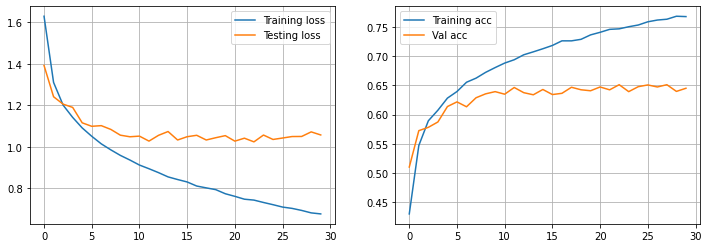

In [7]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Val acc')
ax2.legend()
ax2.grid()

#### Overall accuracy evaluation on test set
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [8]:
loss_train, metric_train = model.evaluate(X_train, Y_train, verbose=0)
loss_test, metric_test = model.evaluate(X_test, Y_test, verbose=0)
print('TRAIN: \t loss: {0:.4f}\t accuracy: {1:.4f}'.format(loss_train, metric_train))
print('TEST: \t loss: {0:.4f}\t accuracy: {1:.4f}'.format(loss_test, metric_test))

TRAIN: 	 loss: 0.6319	 accuracy: 0.7886
TEST: 	 loss: 1.0565	 accuracy: 0.6452


## Deeper CNN

In [9]:
!pip install wandb

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [10]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

project_id = 'deep-learning-sw08'

wandb: Currently logged in as: fabiangroeger (use `wandb login --relogin` to force relogin)


### Define the network

In [11]:
D = X_train.shape[1:]

# initialize wandb with your project name and optionally with configutations.
run = wandb.init(project=project_id,
           config={
              "learning_rate": 0.005,
              "epochs": 25,
              "batch_size": 64,
               "activation": 'relu',
              "loss_function": "categorical_crossentropy",
              "architecture": "CNN",
              "dataset": "CIFAR-10"
           })
config = wandb.config

def create_model(config):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), input_shape=D, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(loss=config.loss_function, 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate), 
                  metrics=['accuracy'])
    
    return model

tf.keras.backend.clear_session()
model = create_model(config)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


### Compile and train the network
In Keras, we call the methods `compile()` and `fit()`. For the compile phase, we need to specify the **loss** function which should be set in the case of multi-class classification to `categorical_crossentropy`. We also need to specify the optimizer strategy. In this case the `rmsprop` or `adam` can be used.

In [12]:
# in order to get prediction on small subset of images.
val_images, val_labels = X_test[:32], Y_test[:32]

log = model.fit(X_train, Y_train, 
                epochs=config.epochs, 
                batch_size=config.batch_size,
                validation_data=(X_test, Y_test),
                callbacks=[WandbCallback(data_type='image', 
                                   training_data=(val_images, val_labels), 
                                   labels=CLASS_NAMES)],
                verbose=0)

### Evaluate the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

#### Loss evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

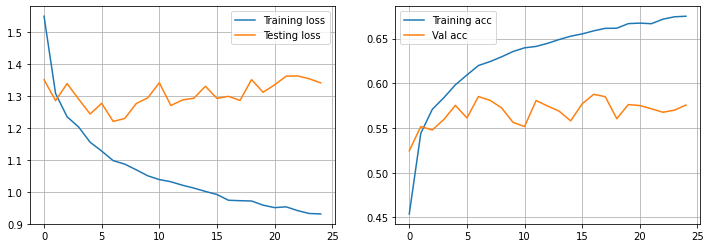

In [13]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Val acc')
ax2.legend()
ax2.grid()

#### Overall accuracy evaluation on test set
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [14]:
loss_train, metric_train = model.evaluate(X_train, Y_train, verbose=0)
loss_test, metric_test = model.evaluate(X_test, Y_test, verbose=0)
print('TRAIN: \t loss: {0:.4f}\t accuracy: {1:.4f}'.format(loss_train, metric_train))
print('TEST: \t loss: {0:.4f}\t accuracy: {1:.4f}'.format(loss_test, metric_test))

# log to wandb
wandb.log({'Train Error Rate': round((1-metric_train)*100, 2)})
wandb.log({'Test Error Rate': round((1-metric_test)*100, 2)})

TRAIN: 	 loss: 0.8537	 accuracy: 0.7012
TEST: 	 loss: 1.3401	 accuracy: 0.5757


## Hyperparameter optimization

In [24]:
def create_model(config):
    model = Sequential()
    
    ### 1. layer
    model.add(Conv2D(filters=config.filters[0], 
                     kernel_size=(config.kernel, config.kernel), 
                     strides=1, 
                     padding="same", 
                     activation=None,
                     input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Activation(config.activation))
    
    ### 2. layer
    model.add(Conv2D(filters=config.filters[0], 
                     kernel_size=(config.kernel, config.kernel), 
                     strides=1, 
                     padding="same", 
                     activation=None))
    model.add(BatchNormalization())
    model.add(Activation(config.activation))
    
    ### 3.+ layers
    for layer in config.filters[1:]:        
        model.add(Conv2D(filters=layer, 
                         kernel_size=(config.kernel, config.kernel), 
                         strides=1, 
                         padding="same", 
                         activation=None))
        model.add(BatchNormalization())
        model.add(Activation(config.activation))
        model.add(MaxPooling2D())
        model.add(Dropout(0.2))
    
    ### 2nd last layer
    model.add(Flatten())
    model.add(tf.keras.layers.Dense(1024, activation=None))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(config.activation))
    model.add(tf.keras.layers.Dropout(0.2))
    
    ### last layer
    model.add(Dense(n_classes, activation='softmax'))
    
    return model

In [25]:
def train():
    # Specify the hyperparameter to be tuned along with
    # an initial value
    config_defaults = {
        'batch_size': 32,
        'learning_rate': 0.001,
        'filters': [32, 64],
        'activation': 'relu',
        'kernel': 3
    }
    
    # Initialize wandb with a sample project name
    wandb.init(project=project_id,
               config=config_defaults)

    # Specify the other hyperparameters to the configuration, if any
    wandb.config.epochs = 30
    wandb.config.loss_function = 'categorical_crossentropy'
    config = wandb.config
    
    # define model
    tf.keras.backend.clear_session()
    model = create_model(config)
    
    # compile model
    model.compile(loss=config.loss_function, 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate), 
                  metrics=['accuracy'])
    
    # train model
    _ = model.fit(X_train, Y_train, 
                epochs=config.epochs, 
                batch_size=config.batch_size,
                validation_data=(X_test, Y_test),
                callbacks=[WandbCallback()],
                verbose=0)
    
    # evaluate model
    loss_test, metric_test = model.evaluate(X_test, Y_test, verbose=0, callbacks=[WandbCallback()])
    wandb.log({'Test Error Rate': round((1-metric_test)*100, 2)})

In [26]:
sweep_config = {
  'method': 'bayes', 
  'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
  },
  'early_terminate':{
      'type': 'hyperband',
      'min_iter': 5
  },
  'parameters': {
      'batch_size': {
          'values': [32, 64, 128, 256]
      },
      'learning_rate': {
          'values': [0.005, 0.001, 0.0005, 0.0001]
      },
      'filters': {
          'values': [
              [32, 64],
              [32, 64, 128],
              [32, 64, 128, 256],
              [32, 64, 128, 256, 512],
          ]
      },
      'activation': {
          'values': ['elu', 'selu']
      },
      'kernel': {
          'values': [3, 5, 7]
      }
  }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project=project_id)
wandb.agent(sweep_id, function=train)

Create sweep with ID: qfnsd2i5
Sweep URL: https://wandb.ai/fabiangroeger/deep-learning-sw08/sweeps/qfnsd2i5


wandb: Agent Starting Run: 1wq3qi69 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	kernel: 3
wandb: 	learning_rate: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


epoch,29
loss,0.24038
accuracy,0.91468
val_loss,0.59809
val_accuracy,0.8216
_runtime,201
_timestamp,1619012482
_step,30
best_val_loss,0.55854
best_epoch,19
Test Error Rate,17.84


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
val_loss,█▇▅▅▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇█▇█████████████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
Test Error Rate,▁


wandb: Agent Starting Run: h4a2cx4z with config:
wandb: 	activation: elu
wandb: 	batch_size: 256
wandb: 	filters: [32, 64, 128, 256]
wandb: 	kernel: 5
wandb: 	learning_rate: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


epoch,5
loss,0.8928
accuracy,0.68764
val_loss,0.94993
val_accuracy,0.6772
_runtime,41
_timestamp,1619012527
_step,5
best_val_loss,0.94993
best_epoch,5


epoch,▁▂▄▅▇█
loss,█▅▃▂▂▁
accuracy,▁▄▆▇▇█
val_loss,█▃▂▂▁▁
val_accuracy,▁▄▆▇▇█
_runtime,▁▂▄▅▆█
_timestamp,▁▂▄▅▆█
_step,▁▂▄▅▇█


wandb: Agent Starting Run: 6f65lk26 with config:
wandb: 	activation: elu
wandb: 	batch_size: 32
wandb: 	filters: [32, 64]
wandb: 	kernel: 3
wandb: 	learning_rate: 0.005
wandb: WARNING Ignored wandb.init() arg project when running a sweep


epoch,21
loss,0.2068
accuracy,0.92992
val_loss,1.53261
val_accuracy,0.7004
_runtime,171
_timestamp,1619012707
_step,21
best_val_loss,0.8578
best_epoch,7


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇███████
val_loss,▅▃▃▁▂▄▂▁▂▂▃▃▄▄▅▅▅▆▆▆▇█
val_accuracy,▁▄▄▆▅▃▆█▇▇▇▇▇█▇▇█████▇
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 6huxsqnn with config:
wandb: 	activation: elu
wandb: 	batch_size: 64
wandb: 	filters: [32, 64, 128, 256]
wandb: 	kernel: 3
wandb: 	learning_rate: 0.005
wandb: WARNING Ignored wandb.init() arg project when running a sweep


epoch,29
loss,0.1469
accuracy,0.94848
val_loss,0.72839
val_accuracy,0.8314
_runtime,172
_timestamp,1619012892
_step,30
best_val_loss,0.56902
best_epoch,9
Test Error Rate,16.86


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████████████
val_loss,█▄▃▂▄▂▁▃▁▁▁▁▁▁▁▁▂▂▂▂▂▃▂▂▂▂▂▂▂▂
val_accuracy,▁▄▅▆▄▆▇▆▇▇█▇██████▇██▇████████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
Test Error Rate,▁


wandb: Agent Starting Run: ilg2ulct with config:
wandb: 	activation: elu
wandb: 	batch_size: 32
wandb: 	filters: [32, 64, 128, 256]
wandb: 	kernel: 5
wandb: 	learning_rate: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


epoch,29
loss,0.09866
accuracy,0.96592
val_loss,0.81733
val_accuracy,0.8189
_runtime,292
_timestamp,1619013191
_step,30
best_val_loss,0.6058
best_epoch,6
Test Error Rate,18.11


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇███████████████
val_loss,█▆▃▂▂▁▁▁▂▂▂▂▂▂▂▂▃▃▃▂▃▃▃▃▃▃▃▃▄▄
val_accuracy,▁▂▅▆▆▇▇▇▇▇▇▇▇▇▇███████████████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
Test Error Rate,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: irecj4zb with config:
wandb: 	activation: elu
wandb: 	batch_size: 256
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	kernel: 5
wandb: 	learning_rate: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


epoch,29
loss,0.05786
accuracy,0.98012
val_loss,0.96222
val_accuracy,0.8163
_runtime,239
_timestamp,1619013444
_step,30
best_val_loss,0.67725
best_epoch,4
Test Error Rate,18.36


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇█████████████████
val_loss,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂
val_accuracy,▁▅▆▇▇▇▇█▇█████████████████████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
Test Error Rate,▁


wandb: Agent Starting Run: h6xwolsn with config:
wandb: 	activation: elu
wandb: 	batch_size: 256
wandb: 	filters: [32, 64, 128]
wandb: 	kernel: 3
wandb: 	learning_rate: 0.005
wandb: WARNING Ignored wandb.init() arg project when running a sweep


epoch,8
loss,0.47619
accuracy,0.83128
val_loss,0.74402
val_accuracy,0.7671
_runtime,41
_timestamp,1619013491
_step,8
best_val_loss,0.72567
best_epoch,6


epoch,▁▂▃▄▅▅▆▇█
loss,█▅▄▃▂▂▂▁▁
accuracy,▁▄▅▆▇▇▇██
val_loss,█▃▂▂▁▁▁▁▁
val_accuracy,▁▅▇▇█████
_runtime,▁▂▃▄▅▅▆▇█
_timestamp,▁▂▃▄▅▅▆▇█
_step,▁▂▃▄▅▅▆▇█


wandb: Agent Starting Run: ryu3rnc9 with config:
wandb: 	activation: elu
wandb: 	batch_size: 64
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	kernel: 7
wandb: 	learning_rate: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


epoch,29
loss,0.04641
accuracy,0.98374
val_loss,1.03316
val_accuracy,0.8112
_runtime,482
_timestamp,1619013982
_step,30
best_val_loss,0.63105
best_epoch,5
Test Error Rate,18.88


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▆▆▆▇▇▇▇▇██████████████████
val_loss,█▄▂▂▂▁▂▂▂▂▃▃▃▃▄▄▃▃▄▄▄▄▄▄▄▄▄▄▄▄
val_accuracy,▁▄▆▆▆▇▇▇▇▇▇█▇▇▇▇██████████████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
Test Error Rate,▁


wandb: Agent Starting Run: kjumgskb with config:
wandb: 	activation: elu
wandb: 	batch_size: 64
wandb: 	filters: [32, 64, 128, 256]
wandb: 	kernel: 3
wandb: 	learning_rate: 0.005
wandb: WARNING Ignored wandb.init() arg project when running a sweep


epoch,29
loss,0.14459
accuracy,0.9495
val_loss,0.70783
val_accuracy,0.8361
_runtime,170
_timestamp,1619014159
_step,30
best_val_loss,0.57535
best_epoch,10
Test Error Rate,16.39


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████████████
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▁▂▂▁▂▂▂▂
val_accuracy,▁▃▄▆▆▇▇▇▇▇▇▇▇▇███▇████████████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
Test Error Rate,▁


wandb: Agent Starting Run: cbs958nu with config:
wandb: 	activation: selu
wandb: 	batch_size: 256
wandb: 	filters: [32, 64, 128, 256]
wandb: 	kernel: 7
wandb: 	learning_rate: 0.005
wandb: WARNING Ignored wandb.init() arg project when running a sweep


epoch,11
loss,0.58247
accuracy,0.797
val_loss,0.83511
val_accuracy,0.733
_runtime,105
_timestamp,1619014270
_step,11
best_val_loss,0.83511
best_epoch,11


epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▅▅▄▃▃▂▂▂▁▁▁
accuracy,▁▃▃▄▅▆▆▇▇▇██
val_loss,██▅▅▃▃▃▂▂▂▁▁
val_accuracy,▁▁▄▄▆▆▆▇▇▇██
_runtime,▁▂▂▃▄▄▅▅▆▇▇█
_timestamp,▁▂▂▃▄▄▅▅▆▇▇█
_step,▁▂▂▃▄▄▅▅▆▇▇█


wandb: Agent Starting Run: cc5bdifn with config:
wandb: 	activation: elu
wandb: 	batch_size: 256
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	kernel: 7
wandb: 	learning_rate: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep


epoch,17
loss,0.09004
accuracy,0.96774
val_loss,0.96982
val_accuracy,0.7877
_runtime,219
_timestamp,1619014502
_step,17
best_val_loss,0.69809
best_epoch,7


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▃▄▅▅▆▆▆▇▇▇▇██████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_accuracy,▁▄▇▇▇▇██▇█████████
_runtime,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: fft4dvao with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	filters: [32, 64, 128, 256]
wandb: 	kernel: 5
wandb: 	learning_rate: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


epoch,6
loss,0.58155
accuracy,0.79622
val_loss,0.75661
val_accuracy,0.7471
_runtime,49
_timestamp,1619014567
_step,6
best_val_loss,0.75661
best_epoch,6


epoch,▁▂▃▅▆▇█
loss,█▄▃▂▂▁▁
accuracy,▁▄▅▆▇██
val_loss,█▄▄▂▁▂▁
val_accuracy,▁▅▆▇▇▇█
_runtime,▁▂▃▄▆▇█
_timestamp,▁▂▃▄▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: eb1v0e7f with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	kernel: 3
wandb: 	learning_rate: 0.005
wandb: WARNING Ignored wandb.init() arg project when running a sweep


epoch,29
loss,0.10193
accuracy,0.96482
val_loss,0.86834
val_accuracy,0.8215
_runtime,189
_timestamp,1619014845
_step,30
best_val_loss,0.6345
best_epoch,8
Test Error Rate,17.85


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇███████████████
val_loss,█▅▃▂▂▁▁▁▁▂▁▁▁▂▂▁▁▁▂▂▂▂▂▂▃▃▃▃▂▃
val_accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇▇▇████████████▇██
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
Test Error Rate,▁


wandb: Agent Starting Run: zxbm96l5 with config:
wandb: 	activation: elu
wandb: 	batch_size: 64
wandb: 	filters: [32, 64, 128, 256]
wandb: 	kernel: 3
wandb: 	learning_rate: 0.005
wandb: WARNING Ignored wandb.init() arg project when running a sweep


epoch,29
loss,0.14671
accuracy,0.94828
val_loss,0.71568
val_accuracy,0.8354
_runtime,169
_timestamp,1619015247
_step,30
best_val_loss,0.56946
best_epoch,8
Test Error Rate,16.46


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████████████
val_loss,█▅▃▄▄▂▁▂▁▂▁▂▂▁▁▂▂▂▁▂▂▃▂▂▂▃▃▃▃▃
val_accuracy,▁▃▅▅▅▆▇▇█▇▇▇███▇▇█████████████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
Test Error Rate,▁


wandb: Agent Starting Run: r3fufon6 with config:
wandb: 	activation: elu
wandb: 	batch_size: 64
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	kernel: 3
wandb: 	learning_rate: 0.005
wandb: WARNING Ignored wandb.init() arg project when running a sweep


epoch,29
loss,0.08601
accuracy,0.97074
val_loss,0.73096
val_accuracy,0.8449
_runtime,189
_timestamp,1619015616
_step,30
best_val_loss,0.56679
best_epoch,6
Test Error Rate,15.51


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇████████████████
val_loss,▇█▃▃▂▂▁▁▁▁▁▂▂▂▁▁▃▂▃▃▃▃▂▃▃▃▃▃▄▃
val_accuracy,▁▂▆▅▆▇▇▇▇▇▇█▇▇██▇██▇███▇██▇███
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
Test Error Rate,▁


wandb: Agent Starting Run: 13vbgnma with config:
wandb: 	activation: elu
wandb: 	batch_size: 64
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	kernel: 3
wandb: 	learning_rate: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep
